# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1. Import and load 


The goal in this project is to use the transaction, demographic and type of oferts ofered to a user to determine which of the characteristics and variables avaliabñe in the data sets hep us to determinate the success of an offert

In [104]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
% matplotlib inline

import seaborn as sns
sns.set(style = 'whitegrid')


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 2. Data Exploration

In this section we are going to explore the variables and information inside of the three data sets we are goin to use in the project

#### a) Portfolio 

In [105]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [106]:
# see the shape of the data set
portfolio.shape

(10, 6)

In [107]:
#looking for null values in the variables
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

When I look for the null values on the variables I found that no one has null values on their rows

In [108]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


This data set contain only six variables with ten rows that the scribe the offer type and their characteristics 

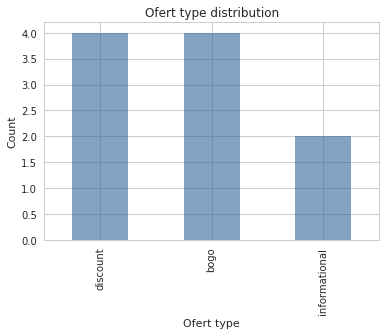

In [109]:
#explore the offer_type

portfolio['offer_type'].value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6))
plt.title('Ofert type distribution')
plt.xlabel('Ofert type')
plt.ylabel('Count')
plt.grid(True)


according to the graph the less use offert type is informational, while discouts and bogo are the most used alternatives.

In [110]:
#chanels distribution
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

The chanels options to send offerts to the clients ar by email, web, mobile and social media

#### b) Profile

In the profie data set we found the information rekated with the client, their demographic features like their age, data where he become a client, his gender, id and income of each one.

In [111]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [112]:
# see the shape of the data set
profile.shape

(17000, 5)

In [113]:
#looking for null value
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We found that there are 2175 null vaues in the gender and income variable and result to be in the same rows, it means that a null in gender match with an income null value.

Text(0,0.5,'Count')

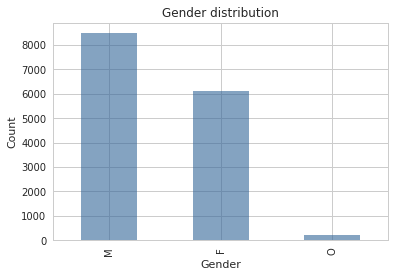

In [114]:
#gender distribution

profile['gender'].value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6))
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.ylabel('Count')


In the case of teh distribution of the gender, more than 8000 clients are male, about 6000 are female and the rest of the clients are others.

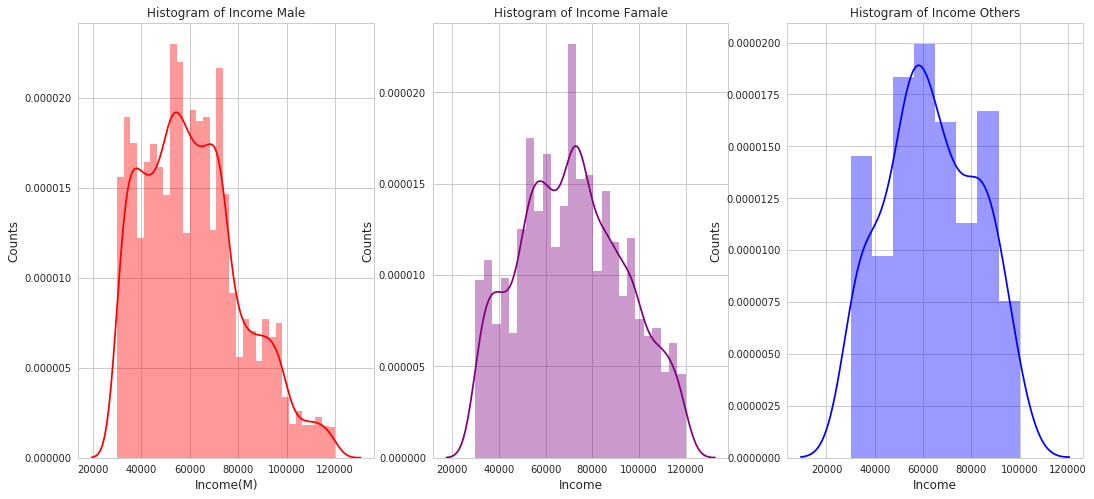

In [115]:
# Plot histograms of income per gender
plt.figure(figsize=[18, 8])

plt.subplot(131)
sns.distplot(profile.loc[profile['gender'] == 'M', 'income'],color='red')
plt.xlabel('Income(M)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of Income Male', fontsize=12);

plt.subplot(132)
sns.distplot(profile.loc[profile['gender'] == 'F', 'income'],color='purple')
plt.xlabel('Income', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of Income Famale', fontsize=12);

plt.subplot(133)
sns.distplot(profile.loc[profile['gender'] == 'O', 'income'],color='blue')
plt.xlabel('Income', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of Income Others', fontsize=12);

When we compare de income with the gender it s posible to see that the male are concentrate below of 8000 of income, while the women has a more wide distibution and concentrates their income between 50000 and 100000, the other genders has income between 50000 and 70000.

In [116]:
# Check the values of the variable age
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [117]:
#check  age=118 with respect to gender and income columns
print(profile[profile['age']==118].count())


age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


in the posible values of the age varible there are an atipic value this is the age of 118 which can be an error in the information because is not a typical value in this variable, and appears to be related with the null values in the data set

Text(0,0.5,'Count')

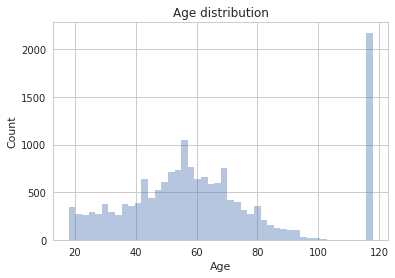

In [118]:
# age distribution

sns.distplot(profile.age, kde=False)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")

In [119]:
# change datatype on became_member_on column.
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

On this part I change the datatype of the variable became member on in a datatime to extract the year and see the distribution of the variable and found that 2017 was the year when we more clients become a member

In [120]:
#extract the year and month of the became member
profile['start_year'] = profile.became_member_on.dt.year

Text(0,0.5,'Count')

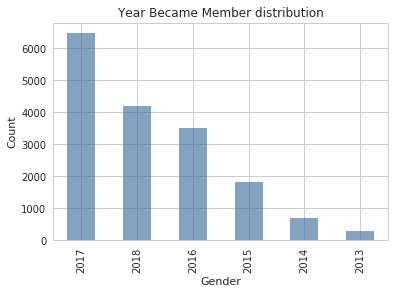

In [121]:
#start_year distribution

profile['start_year'].value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6))
plt.title('Year Became Member distribution')
plt.xlabel('Gender')
plt.ylabel('Count')


In [122]:
profile.head(3)

,age,became_member_on,gender,id,income,start_year
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018


#### c) transcript data

On the transcript data there are information about the oferts sended to a client, if he received, see and use the offert the time he has to use it

In [123]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [124]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [125]:
#explore the event column
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

we see that there are transactions that no necesary are related with offert sends, actually some clients doesn't even received an offert but still buy products, in the group of vlientes who received an ofert the 75% view the offert and from these 58%  use the ofert, these is the behaviour we see in the graph below.

Text(0,0.5,'Count')

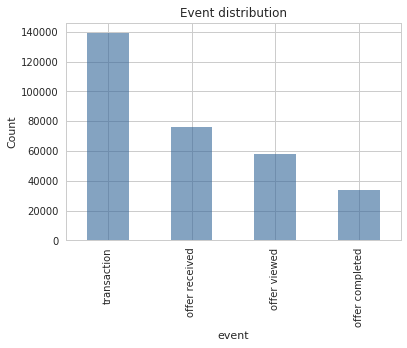

In [126]:
#event distribution

transcript['event'].value_counts().plot(kind='bar',color=(0.2, 0.4, 0.6, 0.6))
plt.title('Event distribution')
plt.xlabel('event')
plt.ylabel('Count')

In [127]:
#keep the transcrips who has profile information for the analysis 
temp = transcript['person'].isin(profile['id'])
transcript_temp = transcript[temp]
transcript_temp.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [128]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# 3. Data Preprocessing

In this part the main idea is to clean the data set to use in the analysis, so there steps like rename variables, create new variables, change datatype, conver to dummie variables if it is necesary and finaly merge the clean data set in the final input information.

##### 3.1) cleaning portfolio dataframe

In [129]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned prortfolio dataframe
    
    '''
    cleaned_portfolio = portfolio.copy()
    # create dummie variables from the channels variable
    
    
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    cleaned_portfolio['bogo'] = cleaned_portfolio['offer_type'].apply(lambda x: 1 if 'bogo' in x else 0)
    cleaned_portfolio['discount'] = cleaned_portfolio['offer_type'].apply(lambda x: 1 if 'discount' in x else 0)
    cleaned_portfolio['informational'] = cleaned_portfolio['offer_type'].apply(lambda x: 1 if 'informational' in x else 0)
    
    #chage data type
    cleaned_portfolio['web']= cleaned_portfolio['web'].astype(object)
    cleaned_portfolio['email'] = cleaned_portfolio['email'].astype(object)
    cleaned_portfolio['mobile'] = cleaned_portfolio['mobile'].astype(object)
    cleaned_portfolio['social'] = cleaned_portfolio['social'].astype(object)
    
    cleaned_portfolio['bogo'] = cleaned_portfolio['bogo'].astype(object)
    cleaned_portfolio['discount'] = cleaned_portfolio['discount'].astype(object)
    cleaned_portfolio['informational'] = cleaned_portfolio['informational'].astype(object)
    
    
    # drop the original variable
    cleaned_portfolio = cleaned_portfolio.drop(['channels'], axis=1)
    cleaned_portfolio = cleaned_portfolio.drop(['offer_type'], axis=1)
    cleaned_portfolio.rename(columns={'id':'Offer_id'}, inplace = True)
    
    return cleaned_portfolio

In [130]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio.head()

,difficulty,duration,Offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


##### 3.2) cleaning profile dataframe

In [131]:
def clean_profile(df = profile):
    
    '''
    clean_profile creates a new clean DataFrame
    
    INPUT
    df: in this case the original profile DataFrame
    
    OUTPUT
    cleaned_profile: the new DataFrame with the fixed and renamed variables
    
    '''
    
    cleaned_profile = profile.copy()
    cleaned_profile = cleaned_profile.dropna(how='any', axis=0)
    
     
    cleaned_profile['F'] = cleaned_profile['gender'].apply(lambda x: 1 if 'F' in x else 0)
    cleaned_profile['M'] = cleaned_profile['gender'].apply(lambda x: 1 if 'M' in x else 0)
    cleaned_profile['O'] = cleaned_profile['gender'].apply(lambda x: 1 if 'O' in x else 0)
    
    #change data type
    
    cleaned_profile['F']= cleaned_profile['F'].astype(object)
    cleaned_profile['M']= cleaned_profile['M'].astype(object)
    cleaned_profile['O']= cleaned_profile['O'].astype(object)
    
    cleaned_profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    cleaned_profile['start_year'] = cleaned_profile.became_member_on.dt.month
    cleaned_profile['start_month'] = cleaned_profile.became_member_on.dt.month
    
    cleaned_profile['start_year']= cleaned_profile['start_year'].astype(object)
    cleaned_profile['start_month']= cleaned_profile['start_month'].astype(object)
    
    
    cleaned_profile.rename(columns={'id':'Client_id'}, inplace = True)
    
    return cleaned_profile

In [132]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,age,became_member_on,gender,Client_id,income,start_year,F,M,O,start_month
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,7,1,0,0,7
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,5,1,0,0,5
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,4,0,1,0,4
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2,0,1,0,2
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,11,0,1,0,11


##### 3.3) cleaning transcript dataframe

In [133]:
def clean_transcript(df = transcript):
    
    '''
    clean_transcript creates a new clean DataFrame
    
    INPUT
    df: in this case the original transcript DataFrame
    
    OUTPUT
    cleaned_transcript: the new DataFrame with the fixed and renamed variables
    
    '''
    
    cleaned_transcript = transcript.copy()
    
    # extract information from the value column
    values = cleaned_transcript ['value'].apply(pd.Series)
    values.offer_id.fillna(values['offer id'], inplace=True)
    cleaned_transcript  = pd.concat([cleaned_transcript , values], axis=1)
    #transcript.head()
    
    # create column with the number of offers each person received ans add to de df
    num_offers = cleaned_transcript[cleaned_transcript['event']=='offer received'].groupby('person').count().reset_index()
    num_offers.rename(columns={'offer_id':'num_offers'},inplace=True)
    cleaned_transcript = pd.merge(cleaned_transcript, num_offers[['person', 'num_offers']], how='left', on='person')
    
    # create dummie variable for each level of the event variable and added to the df
    type_event = pd.get_dummies(cleaned_transcript.event)
    cleaned_transcript = pd.concat([cleaned_transcript, type_event], axis=1)
    cleaned_transcript.rename(columns={'offer_id':'Offer_id'},inplace=True)
    
    # drop and rename columns
    cleaned_transcript.drop(['offer id', 'value', 'reward', 'amount'], axis=1, inplace=True)
    cleaned_transcript.rename(columns={'person':'Client_id'},inplace=True)
    
            
    
    return cleaned_transcript

In [134]:
cleaned_transcript = clean_transcript(transcript)
cleaned_transcript.head()

,event,Client_id,time,Offer_id,num_offers,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,4.0,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,5.0,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,1,0,0


##### 3.4) Merging Data

In [135]:
temp1 = cleaned_transcript.merge(cleaned_profile, on = ['Client_id'])
df = temp1.merge(cleaned_portfolio, how = 'left', on = ['Offer_id'])
df.head()

,event,Client_id,time,Offer_id,num_offers,offer completed,offer received,offer viewed,transaction,age,...,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,1,0,0,75,...,5.0,7.0,5.0,1,1,1,0,1,0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,0,1,0,75,...,5.0,7.0,5.0,1,1,1,0,1,0,0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,4.0,0,0,0,1,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,1,0,0,0,75,...,5.0,7.0,5.0,1,1,1,0,1,0,0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,NaN,4.0,0,0,0,1,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 3.5) Create target variable

This step in where I create the target variable, in my case I define the succes varible as 1 in the case a cliente view the ofert and complete the ofert and 0 in other case, for this I determine if before the transaction the client recieve the offert.

In [136]:
def target_variable(df):
    '''
    Create the target variable to used in the model
    
    INPUT:
    df - the full dataframe 
    
    OUTPUT:
    df - final dataframe
    
    ''' 
    
    
    # identify cases where event is equal to 'offer completed'
    temp = df
    temp = temp[(temp['event']=='offer viewed') | (temp['event']=='offer completed')]
    
    
    # use shift to have a colum comparicion based on client id and offer id
    #this to get the success condition, defined as offer completed and offer viewed.
    temp['p_offer_id'] = temp.groupby(['Client_id', 'Offer_id'])['Offer_id'].shift()
    
    
    # if offer is completed and if it is viewed then put 1 or else 0 in success column. 
    temp['success'] = np.where((temp['event'] == 'offer completed')
                                           & (temp['p_offer_id'] == temp['Offer_id']),
                                           1, 0)
    
    temp.drop(['p_offer_id'], axis=1, inplace=True)
        
    return temp

In [137]:
df = target_variable(df)
df.reset_index()
df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,event,Client_id,time,Offer_id,num_offers,offer completed,offer received,offer viewed,transaction,age,...,duration,reward,web,email,mobile,social,bogo,discount,informational,success
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,0,0,1,0,75,...,7.0,5.0,1,1,1,0,1,0,0,0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,1,0,0,0,75,...,7.0,5.0,1,1,1,0,1,0,0,1
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,4.0,0,0,1,0,75,...,3.0,0.0,0,1,1,1,0,0,1,0
11,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,4.0,0,0,1,0,75,...,7.0,10.0,0,1,1,1,1,0,0,0
14,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,ae264e3637204a6fb9bb56bc8210ddfd,4.0,1,0,0,0,75,...,7.0,10.0,0,1,1,1,1,0,0,1


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 1 to 272761
Data columns (total 29 columns):
event               82304 non-null object
Client_id           82304 non-null object
time                82304 non-null int64
Offer_id            82304 non-null object
num_offers          82304 non-null float64
offer completed     82304 non-null uint8
offer received      82304 non-null uint8
offer viewed        82304 non-null uint8
transaction         82304 non-null uint8
age                 82304 non-null int64
became_member_on    82304 non-null datetime64[ns]
gender              82304 non-null object
income              82304 non-null float64
start_year          82304 non-null object
F                   82304 non-null object
M                   82304 non-null object
O                   82304 non-null object
start_month         82304 non-null object
difficulty          82304 non-null float64
duration            82304 non-null float64
reward              82304 non-null float64
w

# 4. Model

On this section, the objetive is to construct a model to predict the success of the offert, to do these I compare three diferent classification models to find the most apropiate to my data set

In [139]:
def create_model(df, target, target_names, model):
    '''
    Builds classification model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable
    model - the model to evaluate
    
    OUTPUT:
    model - the classification model
    
    '''
    df = df.dropna(how='any', axis=0)
    
    
    X = df.drop(columns=['Client_id', 'Offer_id', 'time', 'became_member_on',
                        'offer completed', 'offer received','offer viewed', 'event',
                        'gender','success'])
    
    y = df.pop(target)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123)
    
    model = model

    model.fit(X_train, y_train)
    
    
    model_predictions = model.predict(X_test)
    print(classification_report(y_test, model_predictions, target_names=target_names))
    
    print("Total model accuracy:\t {}".format(accuracy_score(y_test, model_predictions)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs[:, 1])))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs[:, 1])))
    
        
    return model

In [140]:
X.head()

,num_offers,transaction,age,income,start_year,F,M,O,start_month,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
1,4.0,0,75,100000.0,5,1,0,0,5,5.0,7.0,5.0,1,1,1,0,1,0,0
3,4.0,0,75,100000.0,5,1,0,0,5,5.0,7.0,5.0,1,1,1,0,1,0,0
6,4.0,0,75,100000.0,5,1,0,0,5,0.0,3.0,0.0,0,1,1,1,0,0,1
11,4.0,0,75,100000.0,5,1,0,0,5,10.0,7.0,10.0,0,1,1,1,1,0,0
14,4.0,0,75,100000.0,5,1,0,0,5,10.0,7.0,10.0,0,1,1,1,1,0,0


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 1 to 272761
Data columns (total 29 columns):
event               82304 non-null object
Client_id           82304 non-null object
time                82304 non-null int64
Offer_id            82304 non-null object
num_offers          82304 non-null float64
offer completed     82304 non-null uint8
offer received      82304 non-null uint8
offer viewed        82304 non-null uint8
transaction         82304 non-null uint8
age                 82304 non-null int64
became_member_on    82304 non-null datetime64[ns]
gender              82304 non-null object
income              82304 non-null float64
start_year          82304 non-null object
F                   82304 non-null object
M                   82304 non-null object
O                   82304 non-null object
start_month         82304 non-null object
difficulty          82304 non-null float64
duration            82304 non-null float64
reward              82304 non-null float64
w

##### 4.1) Comparing models

I decide to use the ROC, precision, recal, f1-score as metrics to compare the models, because are the more frequently metrics used to studie the performance of an classification model, in the analysis we see the value in the ROC for the model applied to the total data set, the train data and the test data, the idea is that the value of the metric has to be the more similar in the three set to has better performance and avoid problems like overfitting.

In [142]:
# randomforest
model_rf = create_model(df, 'success', ['failure', 'success'],RandomForestClassifier(max_depth=20, random_state=123))

             precision    recall  f1-score   support

    failure       0.65      0.73      0.69     17323
    success       0.11      0.08      0.09      7369

avg / total       0.49      0.53      0.51     24692

Total model accuracy:	 0.5325611534100113
Train ROC AUC score:	 0.8555405195793143
Test ROC AUC score:	 0.4267903902783093


In [143]:
# gradient boosting
model_gb = create_model(df, 'success', ['failure', 'success'],GradientBoostingClassifier(random_state=123))

             precision    recall  f1-score   support

    failure       0.70      1.00      0.82     17323
    success       0.00      0.00      0.00      7369

avg / total       0.49      0.70      0.58     24692

Total model accuracy:	 0.701482261461202
Train ROC AUC score:	 0.6469083514561877
Test ROC AUC score:	 0.6357060634921712


In [144]:
# AdaBoost
model_ab = create_model(df, 'success', ['failure', 'success'],AdaBoostClassifier(random_state=123))

             precision    recall  f1-score   support

    failure       0.70      1.00      0.82     17323
    success       0.00      0.00      0.00      7369

avg / total       0.49      0.70      0.58     24692

Total model accuracy:	 0.7015227604082294
Train ROC AUC score:	 0.6372747495582557
Test ROC AUC score:	 0.6351444441414533


According with the results I found that te Adaboost has better metrics, more stable in the groups. Thats why I decide to use this model to predict my target variable

In [145]:
model_ab.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 123}

In [146]:
param_grid={'n_estimators': [50, 100, 500],
            'learning_rate': [0.1,0.7, 1],
             'algorithm': ['SAMME.R','SAMME']}

cv = GridSearchCV(model_ab, param_grid=param_grid, n_jobs=-1, scoring = 'roc_auc')

df = df.dropna(how='any', axis=0)    

X = df.drop(columns=['Client_id', 'Offer_id', 'time', 'became_member_on',
                        'offer completed', 'offer received','offer viewed', 'event',
                        'gender','success'])
y = df['success']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

score = cv.fit(X_train, y_train)


In [147]:
# best parámeters
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}

In [148]:
model = AdaBoostClassifier(n_estimators=100,learning_rate=0.1,algorithm='SAMME.R',random_state=42)
best_model = create_model(df, 'success', ['failure', 'success'], model=model)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

    failure       0.70      1.00      0.82     17323
    success       0.00      0.00      0.00      7369

avg / total       0.49      0.70      0.58     24692

Total model accuracy:	 0.7015632593552568
Train ROC AUC score:	 0.6353524701363179
Test ROC AUC score:	 0.6347813000548118


##### 4.1) Feature importance for the selected model

Once I select the model, I want to see wich of th variables used in construct the model has more importance to predict the succes of an offert, the age an the income are the most important variables to has a succesful offert.

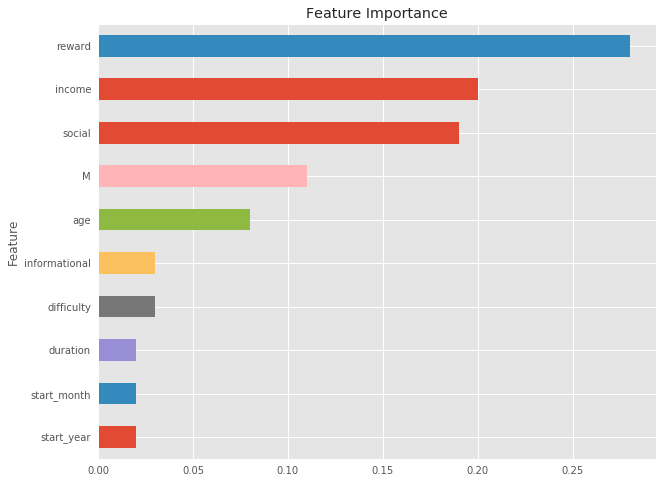

In [149]:
# Feature importance
X = df.drop(columns=['Client_id', 'Offer_id', 'time', 'became_member_on',
                        'offer completed', 'offer received','offer viewed', 'event',
                        'gender','success'])
y = df['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123)

plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize=(10,8))
(pd.Series(best_model.feature_importances_, index=X_train.columns)
   .nlargest(10).sort_values(ascending=True)
   .plot(kind='barh'))  
plt.title("Feature Importance") 
plt.ylabel("Feature");

### 4.1 The number of offer sended to a client influences the success?

In [166]:
# Total number of  offers
df.groupby(['num_offers'])['success'].count()

num_offers
1.0       88
2.0     1346
3.0     7684
4.0    21596
5.0    32188
6.0    19402
Name: success, dtype: int64

It is posible to see that the success seams to be more efective if the clients recive more offer

### 4.2 Relationship between success and income

In [151]:
df.groupby('success')['income'].mean()

success
0    66549.563537
1    68940.052593
Name: income, dtype: float64

It looks like a successful offert are related with more hight income from the clients

### 4.3 Success by gender

In [152]:
df.groupby(['M'])['success'].mean()

M
0    0.314836
1    0.279670
Name: success, dtype: float64

In [153]:
df.groupby(['F'])['success'].mean()

F
0    0.281032
1    0.314342
Name: success, dtype: float64

Analyzing the succes of an offert based on the gender of the client, it looks like the offerts they has a positive impact in the finalization of the transacction in the case of the famale, while in the case of the male they apper to buy the products no jus based on an offert.

### 4.4 Success by offer type

In [154]:
df.groupby(['discount'])['success'].count()

discount
0    46657
1    35647
Name: success, dtype: int64

In [155]:
df.groupby(['informational'])['success'].count()

informational
0    72944
1     9360
Name: success, dtype: int64

In [156]:
df.groupby(['bogo'])['success'].count()

bogo
0    45007
1    37297
Name: success, dtype: int64

If we look the succes in the offer type, I found that the most succesful is the bogo type who has the 45% of the succesfull transacctions, followed for the discount type who has the 43% and the less succesfull is the informational type with 11% of the succes.

### 4.5 Success in gender by event

In [157]:
df.groupby(['gender', 'event'])['success'].count()

gender  event          
F       offer completed    15477
        offer viewed       20786
M       offer completed    16466
        offer viewed       28301
O       offer completed      501
        offer viewed         773
Name: success, dtype: int64

The male complete more offer in relation with the number of offer viewed than the famale, the first complete 74% while the women complete the 58%

In [159]:
df.groupby(['F', 'bogo'])['success'].count()

F  bogo
0  0       25388
   1       20653
1  0       19619
   1       16644
Name: success, dtype: int64

In [160]:
df.groupby(['F', 'discount'])['success'].count()

F  discount
0  0           26103
   1           19938
1  0           20554
   1           15709
Name: success, dtype: int64

Contrasting the offert type with the gender, I found that in the case od the male the offer lead to more succesfull cases in both offer type, but the bogo type is slightly more efficient with 45% of succes than the discount type with 45% of success, while in the case of the famale, the success in both type are less than in the case of male and aditionel thre is no significant diferent in the typeof offert they recived

# 5. Conclusion

###  Reflection

With some analisys of the data I found that contrasting the offert type with the gender,  in the case of the male the offer lead to more succesfull cases in both offer type, but the bogo type is slightly more efficient with 45% of succes than the discount type with 45% of success, while in the case of the famale, the success in both type are less than in the case of male and aditionally there is no significant diferences in the type of offer they recived

In this project, I have the goal of predict offer success based on the available information from the clients and the offerts. I built three classification model to predict the success, a random forest,Gradient Boosting , AdaBoost  and found based on the metrics from the total model, the train and test results that the  AdaBoostClassifier was the best option for may case and the way I work with the data.


The model selected can be used to predict whether an offer is going to be successfully or not. The final model has an accuracy of 70%, not a bad value but can be improved whit a more exacutive work.

* The most important variables to determinate aw offer success result to be:

 -Age 
 
 -Income
 
 -difficulty
 
 -start_month
 
 -num_offers

we also see that the offerts are a litlle more efective with famale than male and that more income leads to more succes.

### Improvement

Explore better prepocesing for the data, a more wide exploratory analysis and better modeling techniques.